In [23]:
import pandas as pd
from recbole.quick_start import load_data_and_model
dataset_name = 'ml-100k'
rec_model_path = '../RecBole/experiments/ml-100k/BPR/BPR-Aug-28-2023_11-27-41.pth'
# rec_model_path = '../RecBole/experiments/ml-100k/SASRec/SASRec-Aug-28-2023_11-31-16.pth'
# rec_model_path = '../RecBole/experiments/ml-100k/LightGCN/LightGCN-Aug-28-2023_11-31-16.pth'

config, rec_model, dataset, train_data, valid_data, test_data = load_data_and_model(
    model_file=rec_model_path,
)

df_item = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.item', sep='\t')
df_inter = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.inter', sep='\t')
if 'ml' in dataset_name:
    df_user = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.user', sep='\t')

03 Oct 18:33    INFO  
General Hyper Parameters:
gpu_id = 1
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = /data/Yucong/anaconda3/lib/python3.9/site-packages/recbole/config/../dataset_example/ml-100k
checkpoint_dir = experiments/ml-100k/BPR
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 500
train_batch_size = 4096
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'group_by': 'user', 'order': 'TO', 'split': {'LS': 'valid_and_test'}, 'mode': 'full'}
repeatable = False
metrics = ['NDCG', 'Recall', 'MRR']
topk = [10, 20]
valid_metric = NDCG@10
valid_metric_bigger = True
eval_batch_size = 4096


In [26]:
from tqdm import tqdm
def get_valid_user_list(df):
    valid_user_list = []
    for id in tqdm(df['user_id:token'].unique().tolist()):
        if len(df_inter[df_inter['user_id:token'] == id]) >=5:
            valid_user_list.append(id)
        if len(valid_user_list) == 1000:
            break
    return valid_user_list
valid_user_list = get_valid_user_list(df_inter)
valid_user_list

100%|██████████| 943/943 [00:00<00:00, 3311.01it/s]


[196,
 186,
 22,
 244,
 166,
 298,
 115,
 253,
 305,
 6,
 62,
 286,
 200,
 210,
 224,
 303,
 122,
 194,
 291,
 234,
 119,
 167,
 299,
 308,
 95,
 38,
 102,
 63,
 160,
 50,
 301,
 225,
 290,
 97,
 157,
 181,
 278,
 276,
 7,
 10,
 284,
 201,
 287,
 246,
 242,
 249,
 99,
 178,
 251,
 81,
 260,
 25,
 59,
 72,
 87,
 42,
 292,
 20,
 13,
 138,
 60,
 57,
 223,
 189,
 243,
 92,
 241,
 254,
 293,
 127,
 222,
 267,
 11,
 8,
 162,
 279,
 145,
 28,
 135,
 32,
 90,
 216,
 250,
 271,
 265,
 198,
 168,
 110,
 58,
 237,
 94,
 128,
 44,
 264,
 41,
 82,
 262,
 174,
 43,
 84,
 269,
 259,
 85,
 213,
 121,
 49,
 155,
 68,
 172,
 19,
 268,
 5,
 80,
 66,
 18,
 26,
 130,
 256,
 1,
 56,
 15,
 207,
 232,
 52,
 161,
 148,
 125,
 83,
 272,
 151,
 54,
 16,
 91,
 294,
 229,
 36,
 70,
 14,
 295,
 233,
 214,
 192,
 100,
 307,
 297,
 193,
 113,
 275,
 219,
 218,
 123,
 158,
 302,
 23,
 296,
 33,
 154,
 77,
 270,
 187,
 170,
 101,
 184,
 112,
 133,
 215,
 69,
 104,
 240,
 144,
 191,
 61,
 142,
 177,
 203,
 21,
 197,
 13

# User Profile

In [43]:
from recbole.utils.case_study import full_sort_topk
def get_instruction_ml_user(idx):
    # user_info
    user_info = df_user[df_user["user_id:token"] == int(idx)]
    user_age = user_info["age:token"].values[0]
    user_gender = 'male' if user_info["gender:token"].values[0] == 'M' else 'female'
    user_occupation = user_info["occupation:token"].values[0]

    # history_inter_info
    df_inter_user = df_inter[df_inter['user_id:token'] == int(idx)]
    his_id_list = df_inter_user['item_id:token'].tolist()[-10:] 
    uid_series = dataset.token2id(dataset.uid_field, [idx])
    topk_score, topk_iid_list = full_sort_topk(uid_series, rec_model, test_data, k=1, device=config['device'])
    rec_list = dataset.id2token(dataset.iid_field, topk_iid_list.cpu()) 

    # next_item_info
    next_item = df_item[df_item["item_id:token"] == int(rec_list)]
    next_item_title = next_item["movie_title:token_seq"].values[0]
    next_item_class = next_item["class:token_seq"].values[0]

    instruction = 'The history films watched by the customer are:\n'
    for i, id in enumerate(his_id_list):
        instruction += f'{i+1}: {df_item[df_item["item_id:token"] == id]["movie_title:token_seq"].values[0]}' + '\n'
        instruction += f'The class of the movie is {df_item[df_item["item_id:token"] == id]["class:token_seq"].values[0]}.\n'

    # print(f"The age of the customer is {user_age}, the gender is {user_gender} and the customer's occupation is {user_occupation}.")


    instruction += f"""
The recommender system suggests the customer to watch this movie with the following title and class:
{next_item_title}.
The class of the movie is {next_item_class}.

Your mission is to infer the customer's information from the history record, such as age, gender, occupation, etc.
You must infer age, gender, and occupation. Do not return other information. And DO NOT return Unknow or Null.
DO NOT RETURN OTHER INFORMATION!!! Only return the JSON format below!!!! So that the system can evaluate your answer.
The output format is using JSON format as follows:
{{
    "user age": "<accurate number of age>",
    "user gender": "male or female",
    "user occupation": "<occupation>"
}}
"""
    return instruction



In [28]:
from tqdm import tqdm
import random
import warnings
import json
warnings.filterwarnings("ignore")

random.shuffle(valid_user_list)


pbar = tqdm(valid_user_list[:1000])
length = 0
for id in pbar:
    length += 1
    if length > 100:
        break
    # user_info
    user_info = df_user[df_user["user_id:token"] == int(id)]
    user_age = user_info["age:token"].values[0]
    user_gender = 'male' if user_info["gender:token"].values[0] == 'M' else 'female'
    user_occupation = user_info["occupation:token"].values[0] 

    dic = {}
    dic["instruction"] = get_instruction_ml_user(str(id))
    dic['input'] = {}
    dic['output'] = f"""{{"user age": {user_age}, "user gender": "{user_gender}", "user occupation": "{user_occupation}"}}"""
    with open(f'{save_path}/train.json', 'a+', encoding='utf-8') as f:
        json.dump(dic, f, ensure_ascii=False)
        f.write('\n')

 11%|█         | 100/943 [00:03<00:29, 28.71it/s]


# Item Popularity

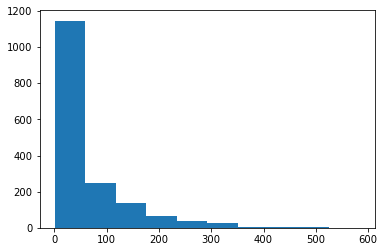

In [20]:
import matplotlib.pyplot as plt

def cal_item_pop(df_inter):
    item_pop = {}
    for i in range(len(df_inter)):
        item_id = df_inter.iloc[i]['item_id:token']
        if item_id in item_pop:
            item_pop[item_id] += 1
        else:
            item_pop[item_id] = 1
    return item_pop

def visualize_item_pop(item_pop):
    plt.hist(item_pop.values(), bins=10)
    plt.show()

item_pop = cal_item_pop(df_inter)
visualize_item_pop(item_pop)

for key, value in item_pop.items():
    if value < 50:
        item_pop[key] = 1
    elif value < 100:
        item_pop[key] = 2
    elif value < 150:
        item_pop[key] = 3
    elif value < 200:
        item_pop[key] = 4
    elif value >= 200:
        item_pop[key] = 5

In [29]:
from recbole.utils.case_study import full_sort_topk

def get_instruction_ml_popularity(idx):
    # user_info
    user_info = df_user[df_user["user_id:token"] == int(idx)]
    user_age = user_info["age:token"].values[0]
    user_gender = 'male' if user_info["gender:token"].values[0] == 'M' else 'female'
    user_occupation = user_info["occupation:token"].values[0]

    # history_inter_info
    df_inter_user = df_inter[df_inter['user_id:token'] == int(idx)]
    his_id_list = df_inter_user['item_id:token'].tolist()[-10:] 
    uid_series = dataset.token2id(dataset.uid_field, [idx])
    topk_score, topk_iid_list = full_sort_topk(uid_series, rec_model, test_data, k=1, device=config['device'])
    rec_list = dataset.id2token(dataset.iid_field, topk_iid_list.cpu()) 

    # next_item_info
    next_item = df_item[df_item["item_id:token"] == int(rec_list)]
    next_item_title = next_item["movie_title:token_seq"].values[0]
    next_item_class = next_item["class:token_seq"].values[0]
    
    instruction = 'The popularity of the movie ranges from 1 to 5, 1 means the least popular and 5 means the most popular.\n'
    instruction += 'The history films watched by the customer are:\n'
    for i, id in enumerate(his_id_list):
        instruction += f'{i+1}: {df_item[df_item["item_id:token"] == id]["movie_title:token_seq"].values[0]}' + '\n'
        instruction += f'The class of the movie is {df_item[df_item["item_id:token"] == id]["class:token_seq"].values[0]}. '
        instruction += f'And the popularity of the movie is {item_pop[id]}.\n'

    instruction += f"""
The recommender system suggests the customer to watch this movie with the following title and class:
{next_item_title}.
The class of the movie is {next_item_class}.

Your mission is to infer the movie's popularity from the history record.
You must infer popularity. Do not return other information. And DO NOT return Unknow or Null.
DO NOT RETURN OTHER INFORMATION!!! Only return the JSON format below!!!! So that the system can evaluate your answer.
The output format is using JSON format as follows:
{{
    "popularity": "<accurate number of popularity in 1-5>"
}}
"""
    return instruction

In [22]:
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings("ignore")

random.shuffle(valid_user_list)

# result_save_path = f'./results/LLaMA2/{dataset_name}/'
# if not os.path.exists(result_save_path):
#     os.makedirs(result_save_path)

count = 0
pbar = tqdm(valid_user_list[:1000])
length = 0
for id in pbar:
    length += 1
    if length > 100:
        break
    # user_info
    user_info = df_user[df_user["user_id:token"] == int(id)]
    user_age = user_info["age:token"].values[0]
    user_gender = 'male' if user_info["gender:token"].values[0] == 'M' else 'female'
    user_occupation = user_info["occupation:token"].values[0] 

    df_inter_user = df_inter[df_inter['user_id:token'] == int(id)]
    his_id_list = df_inter_user['item_id:token'].tolist()[-10:] 
    uid_series = dataset.token2id(dataset.uid_field, [str(id)])
    topk_score, topk_iid_list = full_sort_topk(uid_series, rec_model, test_data, k=1, device=config['device'])
    rec_list = dataset.id2token(dataset.iid_field, topk_iid_list.cpu()) 
    item_popularity = item_pop[int(rec_list)]

    dic = {}
    dic["instruction"] = get_instruction_ml_popularity(str(id))
    dic['input'] = {}
    dic['output'] = f"""{{"popularity": {item_popularity}}}"""
    with open(f'{save_path}/train.json', 'a+', encoding='utf-8') as f:
        json.dump(dic, f, ensure_ascii=False)
        f.write('\n')

 10%|█         | 99/943 [00:05<00:48, 17.31it/s]


In [44]:
rec_model_path_BPR = '../RecBole/experiments/ml-100k/BPR/BPR-Aug-28-2023_11-27-41.pth'
rec_model_path_Sasrec = '../RecBole/experiments/ml-100k/SASRec/SASRec-Aug-28-2023_11-31-16.pth'
rec_model_path_LightGCN = '../RecBole/experiments/ml-100k/LightGCN/LightGCN-Aug-28-2023_11-31-16.pth'

In [45]:
import os
save_path = f'SFT_data/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
with open(f'{save_path}/train.json', 'w', encoding='utf-8') as f:
    f.close()

In [46]:
dataset_name = 'ml-100k'
for rec_model_path in [rec_model_path_BPR, rec_model_path_Sasrec, rec_model_path_LightGCN]:
    config, rec_model, dataset, train_data, valid_data, test_data = load_data_and_model(
        model_file=rec_model_path,
        )

    df_item = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.item', sep='\t')
    df_inter = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.inter', sep='\t')
    if 'ml' in dataset_name:
        df_user = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.user', sep='\t')
        
    random.shuffle(valid_user_list)

    pbar = tqdm(valid_user_list[:1000])
    length = 0
    for id in pbar:
        length += 1
        if length > 100:
            break
        # user_info
        user_info = df_user[df_user["user_id:token"] == int(id)]
        user_age = user_info["age:token"].values[0]
        user_gender = 'male' if user_info["gender:token"].values[0] == 'M' else 'female'
        user_occupation = user_info["occupation:token"].values[0] 

        dic = {}
        dic["instruction"] = get_instruction_ml_user(str(id))
        dic['input'] = {}
        dic['output'] = f"""{{"user age": {user_age}, "user gender": "{user_gender}", "user occupation": "{user_occupation}"}}"""
        with open(f'{save_path}/train.json', 'a+', encoding='utf-8') as f:
            json.dump(dic, f, ensure_ascii=False)
            f.write('\n')
            f.close()

    random.shuffle(valid_user_list)
    pbar = tqdm(valid_user_list[:1000])
    length = 0
    for id in pbar:
        length += 1
        if length > 100:
            break
        # user_info
        user_info = df_user[df_user["user_id:token"] == int(id)]
        user_age = user_info["age:token"].values[0]
        user_gender = 'male' if user_info["gender:token"].values[0] == 'M' else 'female'
        user_occupation = user_info["occupation:token"].values[0] 

        df_inter_user = df_inter[df_inter['user_id:token'] == int(id)]
        his_id_list = df_inter_user['item_id:token'].tolist()[-10:] 
        uid_series = dataset.token2id(dataset.uid_field, [str(id)])
        topk_score, topk_iid_list = full_sort_topk(uid_series, rec_model, test_data, k=1, device=config['device'])
        rec_list = dataset.id2token(dataset.iid_field, topk_iid_list.cpu()) 
        item_popularity = item_pop[int(rec_list)]

        dic = {}
        dic["instruction"] = get_instruction_ml_popularity(str(id))
        dic['input'] = {}
        dic['output'] = f"""{{"popularity": {item_popularity}}}"""
        with open(f'{save_path}/train.json', 'a+', encoding='utf-8') as f:
            json.dump(dic, f, ensure_ascii=False)
            f.write('\n')
            f.close()


03 Oct 18:50    INFO  
General Hyper Parameters:
gpu_id = 1
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = /data/Yucong/anaconda3/lib/python3.9/site-packages/recbole/config/../dataset_example/ml-100k
checkpoint_dir = experiments/ml-100k/BPR
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 500
train_batch_size = 4096
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'group_by': 'user', 'order': 'TO', 'split': {'LS': 'valid_and_test'}, 'mode': 'full'}
repeatable = False
metrics = ['NDCG', 'Recall', 'MRR']
topk = [10, 20]
valid_metric = NDCG@10
valid_metric_bigger = True
eval_batch_size = 4096


# Item price

In [50]:
from recbole.utils.case_study import full_sort_topk


def get_instruction_steam_price(idx):
    # history_inter_info
    df_inter_user = df_inter[df_inter['user_id:token'] == int(idx)]
    his_id_list = df_inter_user['product_id:token'].tolist()[-10:]
    uid_series = dataset.token2id(dataset.uid_field, [idx])
    topk_score, topk_iid_list = full_sort_topk(uid_series, rec_model, test_data, k=1, device=config['device'])
    rec_list = dataset.id2token(dataset.iid_field, topk_iid_list.cpu()) 
    # next_item_info
    next_item = df_item[df_item["id:token"] == int(rec_list)]
    next_item_title = next_item["app_name:token"].values[0]
    next_item_tag = next_item["genres:token_seq"].values[0]
    next_item_price = next_item["price:float"].values[0]

    # print(f'The price of the game is {next_item_price}.')
    instruction = 'The history games played by the customer are:\n'
    for i, id in enumerate(his_id_list):
        item = df_item[df_item["id:token"] == id]
        item_title = item["app_name:token"].values[0]
        item_tag = item["genres:token_seq"].values[0]
        item_price = item["price:float"].values[0]


        instruction += f'{i+1}: {item_title}' + '\n'
        instruction += f'The tags of the game are {item_tag}.\n'
        instruction += f'The price of the game is {item_price}.\n'

    instruction += f"""
The recommender system suggests the customer to play this game with the following title and tags:
{next_item_title}.
The tags of the game are {next_item_tag}.

Your mission is to infer the game's information from the history record, such as price. \
You must infer price. Do not return other information. And DO NOT return Unknow or Null.
DO NOT RETURN OTHER INFORMATION!!! Only return the JSON format below!!!! So that the system can evaluate your answer.


The output format is using JSON format as follows:
{{
    "Game price": "<Free to Play or only number of the price>"
}}
"""
    return instruction


In [48]:
rec_model_path_BPR = '../RecBole/experiments/steam/BPR/BPR-Aug-28-2023_11-58-38.pth'
rec_model_path_Sasrec = '../RecBole/experiments/steam/SASRec/SASRec-Aug-28-2023_11-58-33.pth'
rec_model_path_LightGCN = '../RecBole/experiments/steam/LightGCN/LightGCN-Aug-28-2023_12-02-29.pth'

In [52]:
from tqdm import tqdm

dataset_name = 'steam'
df_inter = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.inter', sep='\t')
def get_valid_user_list(df):
    valid_user_list = []
    for id in tqdm(df['user_id:token'].unique().tolist()):
        if len(df_inter[df_inter['user_id:token'] == id]) >=5:
            valid_user_list.append(id)
        if len(valid_user_list) == 1000:
            break
    return valid_user_list
valid_user_list = get_valid_user_list(df_inter)
valid_user_list

  0%|          | 9549/2567538 [00:22<1:38:40, 432.07it/s]


[13,
 17,
 31,
 41,
 42,
 75,
 78,
 80,
 85,
 94,
 98,
 100,
 104,
 106,
 109,
 112,
 115,
 122,
 136,
 149,
 154,
 155,
 158,
 159,
 160,
 164,
 171,
 199,
 206,
 225,
 230,
 238,
 240,
 249,
 257,
 263,
 272,
 282,
 283,
 285,
 286,
 295,
 298,
 336,
 337,
 340,
 344,
 347,
 352,
 353,
 360,
 371,
 387,
 390,
 401,
 403,
 414,
 421,
 427,
 428,
 430,
 435,
 440,
 449,
 457,
 461,
 505,
 516,
 521,
 522,
 525,
 527,
 542,
 551,
 552,
 563,
 571,
 575,
 577,
 582,
 586,
 611,
 642,
 643,
 651,
 656,
 660,
 671,
 681,
 682,
 691,
 692,
 693,
 696,
 697,
 700,
 702,
 712,
 737,
 742,
 756,
 758,
 759,
 769,
 783,
 788,
 789,
 794,
 805,
 808,
 815,
 817,
 823,
 832,
 851,
 858,
 860,
 865,
 875,
 910,
 914,
 920,
 921,
 929,
 939,
 940,
 992,
 996,
 1015,
 1018,
 1028,
 1032,
 1054,
 1081,
 1092,
 1100,
 1108,
 1110,
 1113,
 1152,
 1160,
 1171,
 1180,
 1197,
 1201,
 1206,
 1214,
 1223,
 1226,
 1227,
 1232,
 1235,
 1249,
 1283,
 1286,
 1291,
 1294,
 1304,
 1334,
 1335,
 1336,
 1341,
 1357

In [53]:
dataset_name = 'steam'
for rec_model_path in [rec_model_path_BPR, rec_model_path_Sasrec, rec_model_path_LightGCN]:
    config, rec_model, dataset, train_data, valid_data, test_data = load_data_and_model(
        model_file=rec_model_path,
        )

    df_item = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.item', sep='\t')
    df_inter = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.inter', sep='\t')
    if 'ml' in dataset_name:
        df_user = pd.read_csv(f'dataset/{dataset_name}/{dataset_name}.user', sep='\t')
        
    random.shuffle(valid_user_list)

    pbar = tqdm(valid_user_list[:1000])
    length = 0
    for id in pbar:
        length += 1
        if length > 100:
            break
        df_inter_user = df_inter[df_inter['user_id:token'] == int(id)]
        his_id_list = df_inter_user['product_id:token'].tolist()[-10:]
        uid_series = dataset.token2id(dataset.uid_field, [str(id)])
        topk_score, topk_iid_list = full_sort_topk(uid_series, rec_model, test_data, k=1, device=config['device'])
        rec_list = dataset.id2token(dataset.iid_field, topk_iid_list.cpu()) 
        # next_item_info
        next_item = df_item[df_item["id:token"] == int(rec_list)]
        next_item_title = next_item["app_name:token"].values[0]
        next_item_tag = next_item["genres:token_seq"].values[0]
        next_item_price = next_item["price:float"].values[0]
    
        dic = {}
        dic["instruction"] = get_instruction_steam_price(str(id))
        dic['input'] = {}
        dic['output'] = f"""{{"price_acc": {next_item_price}}}"""
        with open(f'{save_path}/train.json', 'a+', encoding='utf-8') as f:
            json.dump(dic, f, ensure_ascii=False)
            f.write('\n')
            f.close()


03 Oct 18:59    INFO  
General Hyper Parameters:
gpu_id = 6
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = dataset/steam
checkpoint_dir = experiments/steam/BPR
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 500
train_batch_size = 4096
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'group_by': 'user', 'order': 'TO', 'split': {'LS': 'valid_and_test'}, 'mode': 'full'}
repeatable = False
metrics = ['NDCG', 'Recall', 'MRR']
topk = [10, 20]
valid_metric = NDCG@10
valid_metric_bigger = True
eval_batch_size = 4096
metric_decimal_place = 4

Dataset Hyper Parameters:
field_separator = 	
seq_separ

In [47]:
import re
dic = "{\"popularity\": 5}"
json_part = re.search(r'\{(.+?)\}', dic, re.DOTALL).group()
json_data = json.loads(json_part.replace(",", ''))
json_data

{'popularity': 5}